In [10]:
#### LIBRARIES NEEDED ####

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import time
import pandas as pd
import datetime

In [2]:
#### FUNCTIONS ####


## Get Influenza's related words

def get_outlinks(url):
    '''This function takes the out links of a page given in url.
        /wiki is the starting tag of wikipedia pages
        PMID is the tag for counting the citations in a page (we are not interested about it)'''
    
    base_wiki_url = "https://it.wikipedia.org/wiki/"
    
    # Request the page
    page_response = requests.get(url)
    
    # Parse the page
    soup = BeautifulSoup(page_response.content, "html.parser")
    
    #Add out-links
    edges = []
    one_hop_links = []
    
    # Get neighbors of seed-url
    for link in soup.find_all('a'):
        temp = str(link.get('href'))
        if temp[0:5] == "/wiki" and "PMID" not in temp and ":" not in temp and "secolo" not in temp:
            try:
                int(temp[-4:])
            except:
                one_hop_links.append(temp[6:])
                edges.append(frozenset(["influenza", temp[6:]]))
    
    one_hop_links = list(set(one_hop_links))
    
    print(one_hop_links)
        
    for page in one_hop_links[:10]:
        
        url = base_wiki_url + page
        
        # Request the page
        page_response = requests.get(url)
        
        # Parse the page
        soup = BeautifulSoup(page_response.content, "html.parser")
        
        # Get neighbors of seed-url
        for link in soup.find_all('a'):
            temp = str(link.get('href'))
            if temp[0:5] == "/wiki" and "PMID" not in temp and ":" not in temp and "secolo" not in temp:
                try:
                    int(temp[-4:])
                except:
                    edges.append(frozenset([page, temp[6:]]))
    
    return edges

def get_data(words):
    
    if len(words) > 10:
        return print("No man, you can put just 10 words maximum")

    bs_url = "https://tools.wmflabs.org/pageviews/?project=it.wikipedia.org&platform=all-access&agent=user&range=all-time&pages="+"|".join(words)

    driver = webdriver.Chrome()
    driver.get(bs_url)
    
    time.sleep(10)

    first_click = driver.find_elements_by_tag_name("button")
    first_click[6].click()
    
    driver.find_element_by_class_name("download-csv").click()




# Pipeline

- Get Influenza's related words
- Get Data and Ground Truth
- Build Time Series
- Measure Correlation
- Model it!

### Get Influenza's related words

Explain what we're going to do

In [11]:
# Starting Link
seed_url = "https://it.wikipedia.org/wiki/Influenza"

wiki_links = get_outlinks(seed_url)

['Sindrome_di_Reye', 'Legionellosi', 'Naso', 'EMedicine', 'Sarcoidosi', 'Testa', 'Influenza_spagnola', 'Salasso', 'Fotofobia', 'Otite', 'Bronchiolite_obliterante', 'Istituto_Superiore_di_Sanit%C3%A0', 'Pneumomediastino', 'Rinite_allergica', 'Rinite_vasomotoria', 'Vaccino_influenza_stagionale', 'Virus_parainfluenzali_umani', 'Digital_object_identifier', 'Aspergillosi_broncopolmonare_allergica', 'Insufficienza_respiratoria', 'Organizzazione_Mondiale_della_Sanit%C3%A0', 'Berilliosi', 'Setto_nasale#Ematoma_del_setto_nasale', 'Antivirali', 'Bronchiectasia', 'Sindrome_di_Mendelson', 'Malattia_polmonare_restrittiva', 'Tonsille', 'Wendell_Stanley', 'Organizzazione_mondiale_della_sanit%C3%A0', 'Influenzavirus_C', 'Frank_Macfarlane_Burnet', 'Laringospasmo', 'Edema_polmonare', 'Reazioni_di_ipersensibilit%C3%A0#Ipersensibilit.C3.A0_di_Tipo_I_-_Tipo_anafilattico', 'Malattia_da_reflusso_faringo-laringeo', 'Tosse', 'Panbronchiolite_diffusa', 'Rinite_medicamentosa', 'Epiglottide', 'Polmonite_interstiz

In [12]:
wiki_links

[frozenset({'Microscopio', 'influenza'}),
 frozenset({'Medicina_generale', 'influenza'}),
 frozenset({'Pneumologia', 'influenza'}),
 frozenset({'Malattia_infettiva', 'influenza'}),
 frozenset({'Medical_Subject_Headings', 'influenza'}),
 frozenset({'MedlinePlus', 'influenza'}),
 frozenset({'EMedicine', 'influenza'}),
 frozenset({'Malattia_infettiva', 'influenza'}),
 frozenset({'Virus_a_RNA', 'influenza'}),
 frozenset({'Orthomyxoviridae', 'influenza'}),
 frozenset({'Febbre', 'influenza'}),
 frozenset({'Rinorrea', 'influenza'}),
 frozenset({'Mialgia', 'influenza'}),
 frozenset({'Artralgia', 'influenza'}),
 frozenset({'Cefalea', 'influenza'}),
 frozenset({'Tosse', 'influenza'}),
 frozenset({'Nausea', 'influenza'}),
 frozenset({'Vomito', 'influenza'}),
 frozenset({'Gastroenterite', 'influenza'}),
 frozenset({'Polmonite', 'influenza'}),
 frozenset({'Asma', 'influenza'}),
 frozenset({'Scompenso_cardiaco', 'influenza'}),
 frozenset({'Contagio', 'influenza'}),
 frozenset({'Espettorato', 'influe

In [34]:
a = [frozenset([4,5]),frozenset([4,5]),frozenset([5,6])]

In [35]:
set(a)

{frozenset({5, 6}), frozenset({4, 5})}

### Get Data and Ground Truth

Wikipedia Data

In [261]:
from functools import reduce

def get_week_number(entire_date):
    return entire_date.date().isocalendar()[1]

def get_year(entire_date):
    return entire_date.year

def merge_df(a,b):
    return a.append(b)

In [220]:
# choosen manually now
related_words = ["influenza", "febbre", "vomito"]

#Download data
get_data(related_words)

In [430]:
# Read data
flu_data = pd.read_csv("flu_data.csv")

# Convert date to datetime
flu_data["Date"] = pd.to_datetime(flu_data["Date"], yearfirst=True)

# Get week number and year
flu_data["Week"] = flu_data["Date"].apply(get_week_number)
flu_data["Year"] = flu_data["Date"].apply(get_year)

# Group by week number and year
flu_data = flu_data.groupby(["Year", "Week"]).sum()
flu_data = flu_data.stack()

weeks_of_interest = {2015: [[42,53]], 2016: [[1,16], [42,52]], 2017: [[1,17], [42,52]], 2018: [[1,17]]}

# Merging Dataframes
temp = []
for k,v in weeks_of_interest.items():
    for elem in v:
        temp.append(flu_data.loc[k,list(range(elem[0],elem[1]+1))])
        
        
flu_data = reduce(merge_df, temp).unstack()

Influnet Data

In [443]:
import glob
import matplotlib.pyplot as plt
# Take the csv files from influnet folder clean the dataframes and return a dataframe containing the ground truth
# the gt dataframe has two columns: the week and the incidence value

files = glob.glob("influnet/*")
temp_gt = []
for file in files:
    print("Adding file " + file + " ...")
    temp = pd.read_csv(file, header=None)
    temp = temp[[0,4]]
    temp = temp.drop(temp.index[0:3])
    temp = temp.replace(to_replace=",", value=".", regex=True)
    temp[4] = pd.to_numeric(temp[4])
    temp = temp.reset_index(drop=True)
    temp.columns=["Week","Incidence"]
    temp_gt.append(temp)

gt = pd.concat(temp_gt, axis=0, ignore_index=True)

Adding file influnet\influnet_1516.csv ...
Adding file influnet\influnet_1617.csv ...
Adding file influnet\influnet_1718.csv ...


In [444]:
def get_year_influnet(date):
    return int(date[:4])

def get_week_influnet(date):
    return int(date[5:])

In [445]:
gt["Year"] = gt["Week"].apply(get_year_influnet)
gt["Week"] = gt["Week"].apply(get_week_influnet)

In [446]:
flu_data["GT"] = ["0" for _ in range(flu_data.shape[0])]

In [447]:
def match_data(year,week):
    val = gt["Incidence"].loc[(gt["Year"] == year) & (gt["Week"] == week)]
    return float(val)

In [448]:
flu_data = flu_data.stack()

In [449]:
for year in flu_data.index.levels[0]:
    for week in flu_data.index.levels[1]:
        try:
            flu_data.loc[year,[week],"GT"] = match_data(year,week)
        except:
            pass

In [450]:
flu_data = flu_data.unstack()

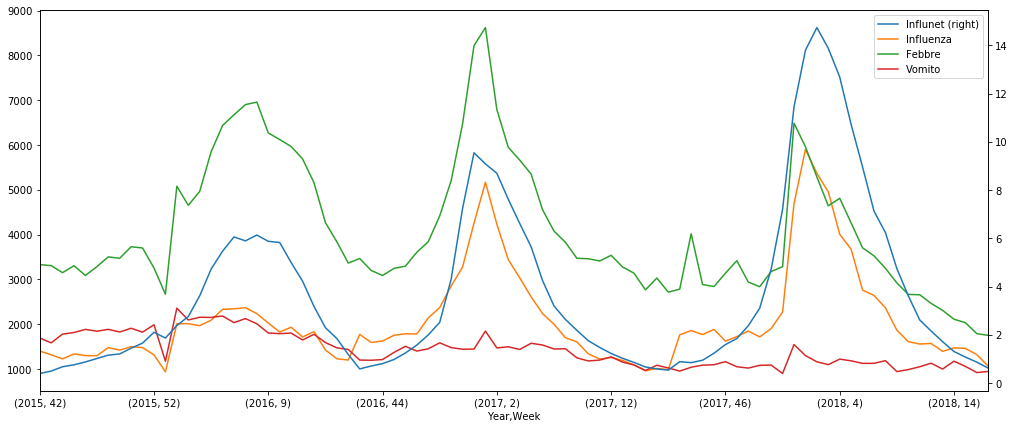

In [455]:
flu_data.GT.plot(secondary_y=True, label="Influnet", figsize=(17,7), legend=True)
flu_data.Influenza.plot(label="Influenza", legend=True)
flu_data.Febbre.plot(label="Febbre", legend=True)
flu_data.Vomito.plot(label="Vomito", legend=True)
plt.show()